## Text Classification Task

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import ConfusionMatrixDisplay

### Data Preparation

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/codehax41/BBC-Text-Classification/master/bbc-text.csv')

In [3]:
df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [4]:
# Check missing values in each column
print(df.isnull().sum())

category    0
text        0
dtype: int64


In [5]:
# Checking how many categories are
df['category'].unique()

array(['tech', 'business', 'sport', 'entertainment', 'politics'],
      dtype=object)

In [6]:
# For modeling we need the the categories to be in numerical format
target = {'tech': 0, 'business': 1, 'sport': 2, 'entertainment': 3, 'politics': 4}
df['target'] = df['category'].map(target)

In [7]:
df

,category,text,target
0,tech,tv future in the hands of viewers with home th...,0
1,business,worldcom boss left books alone former worldc...,1
2,sport,tigers wary of farrell gamble leicester say ...,2
3,sport,yeading face newcastle in fa cup premiership s...,2
4,entertainment,ocean s twelve raids box office ocean s twelve...,3
...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4
2222,entertainment,rem announce new glasgow concert us band rem h...,3
2223,politics,how political squabbles snowball it s become c...,4


In [8]:
nltk.download('stopwords')
# Text preprocessing
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()  # lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    text = re.sub(r'\s+', ' ', text).strip()  # normalize whitespace
    words = text.split()
    words = [stemmer.stem(w) for w in words if w not in stop_words]  # stopword removal + stemming
    return " ".join(words)

df['clean_text'] = df['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adiju\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### EDA

In [9]:
# Checking the distribution of categories
df['category'].value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

<Axes: xlabel='category'>

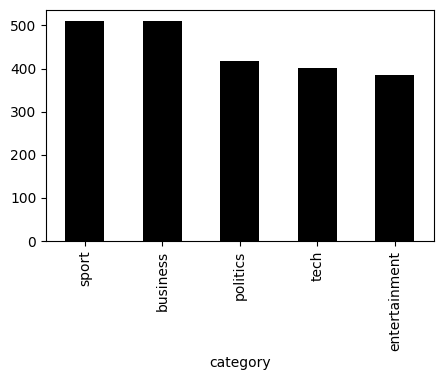

In [10]:
# Visualizing the distribution of categories
df['category'].value_counts().plot(kind='bar', color='black', figsize=(5,3))

<Axes: xlabel='category'>

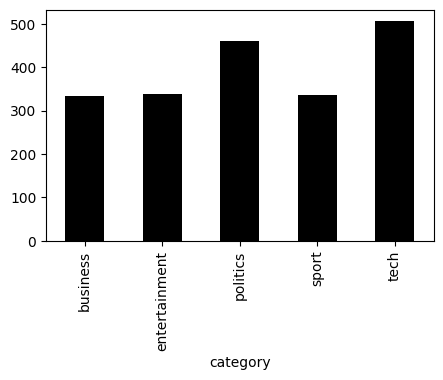

In [11]:
# Vizualizing text length per category
df['text_length'] = df['text'].str.split().str.len()
df.groupby('category')['text_length'].mean().plot(kind='bar', figsize=(5,3), color='black')

### Model Training

In [12]:
# Splitting the dataset
X = df['clean_text']
y = df['category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [13]:
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)

Train size: (1668,)
Test size: (557,)


In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Encoding to be able to use the labels in the models
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_test_enc = encoder.transform(y_test)

#### First model: Logistic Regression

In [15]:
logReg = LogisticRegression(max_iter=1000)
# Train
logReg.fit(X_train_tfidf, y_train_enc)
# Predict
y_pred_logReg = logReg.predict(X_test_tfidf)

print("Logistic Regression Accuracy:", accuracy_score(y_test_enc, y_pred_logReg))
print(classification_report(y_test_enc, y_pred_logReg, target_names=encoder.classes_))

Logistic Regression Accuracy: 0.9784560143626571
               precision    recall  f1-score   support

     business       0.96      0.97      0.96       128
entertainment       0.98      0.99      0.98        97
     politics       0.98      0.96      0.97       104
        sport       1.00      1.00      1.00       128
         tech       0.97      0.97      0.97       100

     accuracy                           0.98       557
    macro avg       0.98      0.98      0.98       557
 weighted avg       0.98      0.98      0.98       557



Confusion Matrix

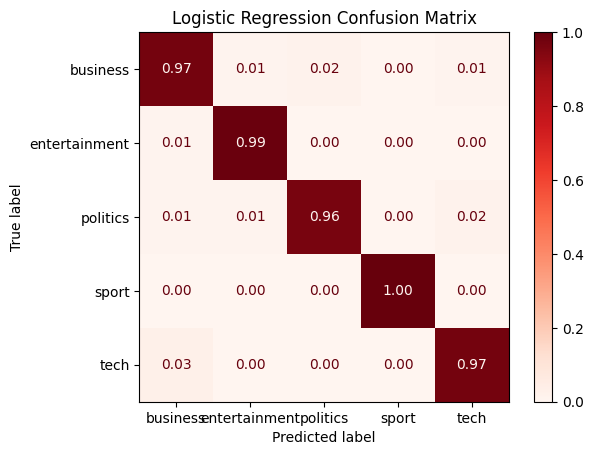

In [16]:
# Confusion Matrix
cm_lr = confusion_matrix(y_test_enc, y_pred_logReg)

# Normalize rows to percentages
cm_percent = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]

# Display matrix
display_cm_lr = ConfusionMatrixDisplay(confusion_matrix=cm_percent, display_labels=encoder.classes_)
display_cm_lr.plot(cmap='Reds', values_format='.2f')

plt.title("Logistic Regression Confusion Matrix")
plt.show()

#### Second model: Naive Bayes

In [17]:
nBayes = MultinomialNB()

# Train the model
nBayes.fit(X_train_tfidf, y_train_enc)

# Make predictions
y_pred_nBayes = nBayes.predict(X_test_tfidf)

print("Naive Bayes Accuracy:", accuracy_score(y_test_enc, y_pred_nBayes))
print(classification_report(y_test_enc, y_pred_nBayes, target_names=encoder.classes_))

Naive Bayes Accuracy: 0.9766606822262118
               precision    recall  f1-score   support

     business       0.96      0.96      0.96       128
entertainment       0.99      0.95      0.97        97
     politics       0.96      0.99      0.98       104
        sport       1.00      1.00      1.00       128
         tech       0.97      0.98      0.98       100

     accuracy                           0.98       557
    macro avg       0.98      0.98      0.98       557
 weighted avg       0.98      0.98      0.98       557



Confussion Matrix

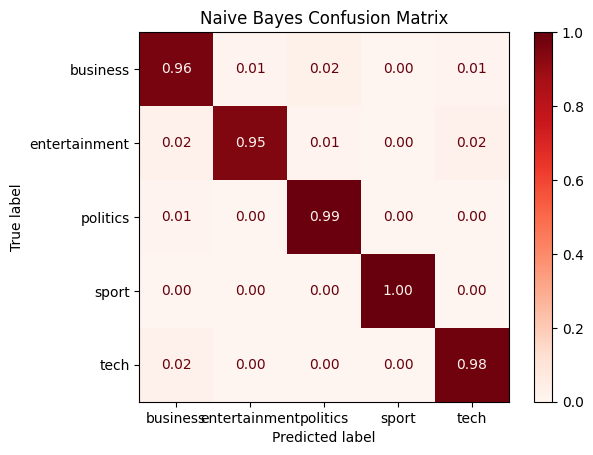

In [18]:
# Confusion Matrix for Naive Bayes
cm_nb = confusion_matrix(y_test_enc, y_pred_nBayes)

# Normalize rows to percentages
cm_percent_nb = cm_nb.astype('float') / cm_nb.sum(axis=1)[:, np.newaxis]

# Display matrix
display_cm_nb = ConfusionMatrixDisplay(confusion_matrix=cm_percent_nb, display_labels=encoder.classes_)
display_cm_nb.plot(cmap='Reds', values_format='.2f')

plt.title("Naive Bayes Confusion Matrix")
plt.show()

#### Model Comparing

Comparing side by side the accuracy score of both models, we can conclude that Logistic Regression model performed slightly better than Naive Bayes model across all categories.

- Logistic Regression Accuracy:&emsp;0.9784560143626571
- Naive Bayes Accuracy:&emsp;&emsp;&emsp;&emsp;0.9748653500897666

### Prediction Function

In [19]:
def predict_category(model, text, vectorizer, encoder):

    # Transform input text
    text_tfidf = vectorizer.transform([text])
    
    # Predict encoded label
    pred_encoded = model.predict(text_tfidf)
    
    # Convert encoded label to real category name
    pred_label = encoder.inverse_transform(pred_encoded)
    
    return pred_label[0]

user_input = input("Enter a sentence to classify: ")

# Logistic Regression
predicted_category_logReg = predict_category(logReg, user_input, vectorizer, encoder)
print(f"Prediction from Logistic Regression model: {predicted_category_logReg}")

# Using Naive Bayes
predicted_category_nBayes = predict_category(nBayes, user_input, vectorizer, encoder)
print(f"Prediction from Naive Bayes model: {predicted_category_nBayes}")


Prediction from Logistic Regression model: entertainment
Prediction from Naive Bayes model: tech


In [21]:
import pickle

# Save Logistic Regression model
with open('logReg.pkl', 'wb') as f:
    pickle.dump(logReg, f)

# Save Naive Bayes model
with open('nBayes.pkl', 'wb') as f:
    pickle.dump(nBayes, f)

# Save TF-IDF vectorizer
with open('vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

# Save Label Encoder
with open('encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)


In [22]:
print(predict_category(logReg, "Manchester United won the match!", vectorizer, encoder))

sport
